<a href="https://colab.research.google.com/github/CagataySencan/TrafficSignRecognition/blob/main/Traffic_Sign_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YOLO V4 Kullanımı İçin Hazırlık


In [ ]:
!ls
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!apt update
!apt-get install libopencv-dev

In [ ]:
%cd /content
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-p6.conv.289

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import  PIL
from PIL import  ImageEnhance , ImageOps , Image
from matplotlib import pyplot
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sbn
from configparser import ConfigParser
from google.colab import drive
import shutil
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Verisetini Kaggle'dan Çekmek İçin Gerekli İşlemler


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
! unzip gtsrb-german-traffic-sign.zip

# Veri Önişleme Aşamaları


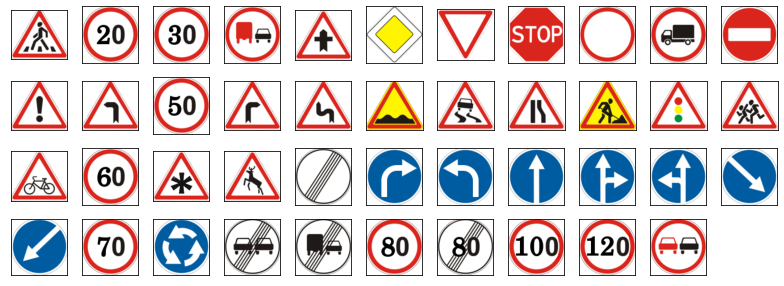

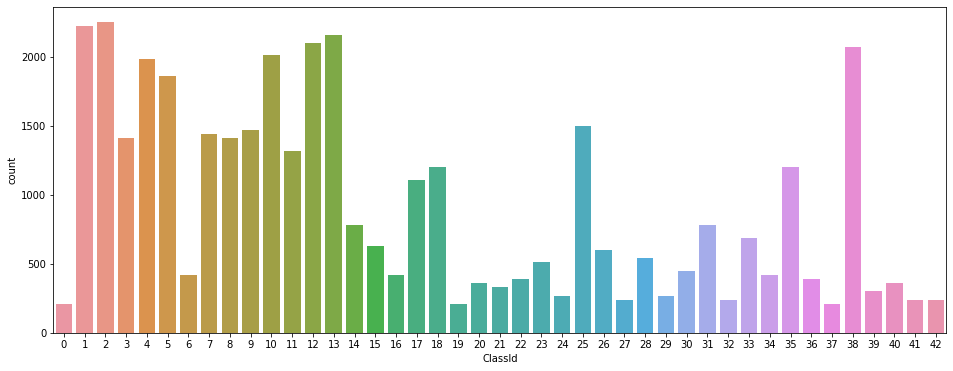

In [ ]:
trainDatas = pd.DataFrame(pd.read_csv('Train.csv'))
testDatas = pd.DataFrame(pd.read_csv('Test.csv'))
metaDatas = pd.read_csv('Meta.csv')
allDatas = pd.concat((trainDatas,testDatas),sort = False).reset_index(drop = True)
classCount = len(trainDatas['ClassId'].value_counts())
classes = { 0:'Hız Limiti (20km/s)',
            1:'Hız Limiti (30km/s)', 
            2:'Hız Limiti (50km/s)', 
            3:'Hız Limiti (60km/s)', 
            4:'Hız Limiti (70km/s)', 
            5:'Hız Limiti (80km/s)', 
            6:'Hız Limitinin bitişi (80km/s)', 
            7:'Hız Limiti (100km/s)', 
            8:'Hız Limiti (120km/s)', 
            9:'Geçiş yok', 
            10:'Ağırlığı 3.5 ton üstü olan araçlar geçemez', 
            11:'Kavşakta geçiş hakkı', 
            12:'Öncelikli yol', 
            13:'Yol ver', 
            14:'Dur', 
            15:'Araç giremez', 
            16:'3.5 Ton üzeri araçlar yasak', 
            17:'Giriş yok', 
            18:'Genel uyarı', 
            19:'Sola tehlikeli viraj', 
            20:'Sağa tehlikeli viraj', 
            21:'Sağa tehlikeli devamlı virajlar', 
            22:'Engebeli yol', 
            23:'Kaygan yol', 
            24:'Sağdan daralan yol', 
            25:'Yol çalışması', 
            26:'Trafik işaretleri', 
            27:'Yaya geçidi', 
            28:'Okul geçidi', 
            29:'Bisiklet yolu', 
            30:'Buzlanmaya dikkat',
            31:'Vahşi hayvan çıkabilir', 
            32:'Hız sınırı sonu', 
            33:'Sadece sağa dönüş var', 
            34:'Sadece sola dönüş var', 
            35:'Dönüş yok', 
            36:'Sola dönüş yok', 
            37:'Sağa dönüş yok', 
            38:'Sağdan gidin', 
            39:'Soldan gidin', 
            40:'Dönüş önceliği', 
            41:'Geçiş olmayan yolun sonu', 
            42:'3.5 Ton üzeri araçlar girebilir' }

# Veri setindeki sınıfları bastıralım
plt.figure(figsize=(11,6))
for i in range(43): 
 plt.subplot(6,11,i+1)
 plt.imshow(Image.open(metaDatas['Path'][i]))
 plt.xticks([])
 plt.yticks([])
 
plt.tight_layout()

# Veri dağılımına bakalım 
plt.figure(figsize=(16,6))
sbn.countplot(x=trainDatas['ClassId'])


In [ ]:
# Eksik veri kontrolü
print("-Eğitim verisi-\n",trainDatas.isnull().sum(),"\n-------------\n","-Test Verisi-\n",testDatas.isnull().sum())
# Eksik veri bulunamadı

# Uyumsuz veri kontrolü, .png ile bitmeyen bir görüntüye sahip olan satır verisetinden çıkarılacak
for i in trainDatas['Path'] : 
  if i.endswith('.png') == False :
    trainDatas.drop(i.index)
    print(i,". satır siliniyor")

for i in testDatas['Path'] :
  if i.endswith('.png') == False:
    testDatas.drop(i.index)
    print(i,". satır siliniyor") 

-Eğitim verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64 
-------------
 -Test Verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


# Veriyi YOLO V4 Formatına Getirme Aşamaları 

In [ ]:
allDatas['center_x'] = (allDatas['Roi.X1'] + allDatas['Roi.X2']) / 2
allDatas['center_y'] = (allDatas['Roi.Y1'] + allDatas['Roi.Y2']) / 2

allDatas = allDatas[['Path','ClassId','center_x','center_y','Width','Height']]


In [ ]:
# Her fotoğraf için annotation txt dosyalarının oluşturulması

for ind in allDatas.index:
    # Normalizasyon işlemi
     image_png = cv2.imread(allDatas['Path'][ind]) 
     h, w = image_png.shape[:2]
     
     sub_r = allDatas.loc[allDatas['Path'] == allDatas['Path'][ind]].copy()
     sub_r['center_x'] = allDatas['center_x'] / w
     sub_r['center_y'] = allDatas['center_y'] / h
     sub_r['Width'] = allDatas['Width'] / w
     sub_r['Height'] = allDatas['Height'] / h

     resulted_frame = sub_r.loc[:, ['ClassId',
                          'center_x',
                          'center_y',
                          'Width',
                          'Height']].copy()
     
     print(sub_r)
     print(resulted_frame)
     
                                 
    
     if resulted_frame.isnull().values.all():
       continue

     savingPath = allDatas['Path'][ind].split(".")[0]

     # annotation txt dosyalarının kaydedileceği yer
     path_to_save = savingPath + '.txt'
     print(path_to_save)

     resulted_frame.to_csv(path_to_save, header=False, index=False, sep=' ')

In [ ]:
# TRAIN AND TEST TXT FILES

df = pd.read_csv('/content/Train.csv')
trainPath = df['Path']
df = pd.read_csv('/content/Test.csv')
testPath = df['Path']

with open('/content/train.txt', 'w') as out:
  for img in [f for f in trainPath]:
    out.write('/content/' + img + '\n')

with open('/content/test.txt', 'w') as out:
  for img in [f for f in testPath]:
    out.write('/content/' + img + '\n')

out.close()

In [ ]:
# CLASSES.NAMES dosyası

c = pd.DataFrame([classes])
c.to_csv('/content/classes.names', header=False, index=False, sep='\n')

In [ ]:
!cd /content/darknet
os.chdir('/content/darknet')
!chmod +x /content/darknet
!make



In [ ]:
# CUSTOM_DATA.DATA dosyası

with open('/content/darknet/cfg/ts_data.data', 'w+') as out:
  out.write('classes = 43\n')
  out.write('train = /content/train.txt\n')
  out.write('valid = /content/valid.txt\n')
  out.write('names = /content/classes.names\n')
  out.write('backup = /content/darknet/backup/')

out.close()


In [ ]:
shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/yolov4_ts_test.cfg", "/content/darknet/cfg")
shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/yolov4_ts_train.cfg", "/content/darknet/cfg")

In [ ]:
!./darknet detector train /content/darknet/cfg/ts_data.data /content/darknet/cfg/yolov4_ts_train.cfg /content/yolov4-p6.conv.289 -thresh 0.25 -dont_show

# Verinin Eğitim Doğrulama ve Test İçin Bölünmesi

In [ ]:
# Eğitim verimizin validation ve eğitim kısmına bölünmesi
X_Train, X_Validate = train_test_split(trainDatas,test_size=0.3,random_state=42)
# Yeni DataFrame oluşturmak için indexleri resetliyoruz
X_Train = X_Train.reset_index(drop = True)
X_Validate = X_Validate.reset_index(drop = True)
batchSize=30
print(X_Train.shape,X_Validate.shape)
# Validation ve eğitim için veriler bölündü

In [ ]:
# Augmentation işlemi
# Realtime augmentation yapıldığı için gözle görülür bir artış olmamakla beraber trainGenerator objesini  eğitimde kullanacağımızda bizim için augmentation yapacak
trainGen = ImageDataGenerator(rotation_range=15,width_shift_range=0.2,height_shift_range=0.2,rescale=1./255,horizontal_flip=True)
trainGenerator = trainGen.flow_from_dataframe(X_Train,x_col = 'Path',y_col = 'ClassId',target_size=(120,120),batch_size=batchSize,class_mode='raw')


validateGen = ImageDataGenerator(rescale=1./255)
validateGenerator = validateGen.flow_from_dataframe(X_Validate,x_col='Path',y_col='ClassId',target_size=(120,120),batch_size=batchSize, class_mode='raw')

testGen = ImageDataGenerator(rescale=1./255)
testGenerator=testGen.flow_from_dataframe(testDatas,x_col='Path',y_col=None,target_size=(120,120),batch_size=15,class_mode=None)